# This Notebook demonstrates the reproducability issue

In [16]:
import numpy as np
import mne
mne.set_config('MNE_BROWSER_BACKEND', 'matplotlib')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from pmf import *
from utils import * 

import nibabel as nib
from nilearn.plotting import plot_anat

# EEG Import

In [17]:
raw = mne.io.read_raw_eeglab(input_fname = "data.set")
raw.info

Reading c:\Users\uzayk\OneDrive\Masaüstü\done projects\Polytopic Matrix Factorization in Neuroscience\github\data.fdt


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,32 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1024.00 Hz
Highpass,0.00 Hz
Lowpass,512.00 Hz


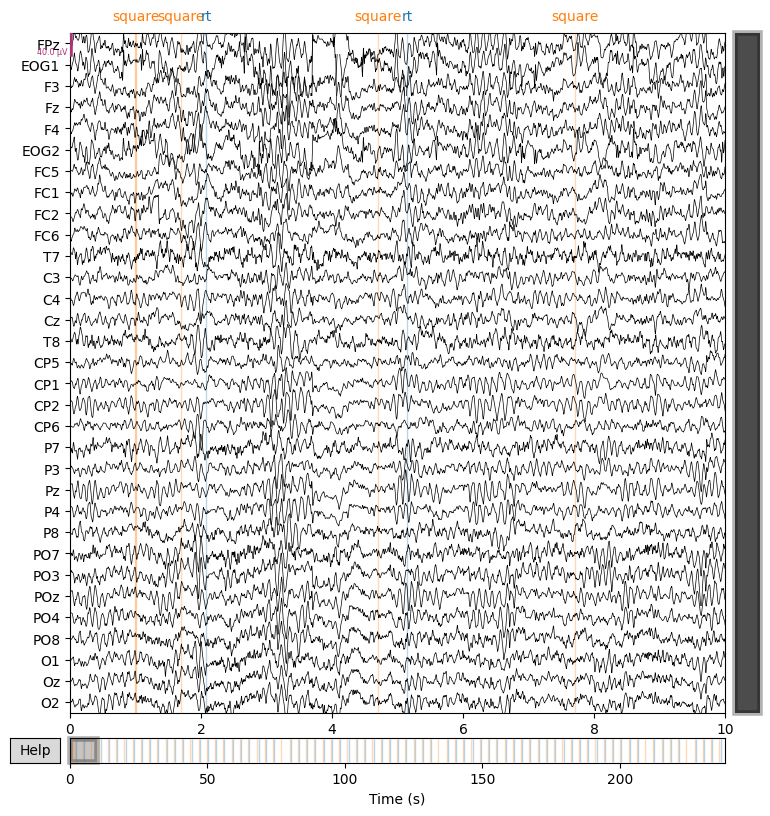

In [3]:
raw.plot(n_channels=len(raw));

# X = WZ

X is regarded as mixtures, which is an M by N matrix.

W represents a linear mapping, which is full column rank M by r matrix. 

Z represents source signals. It is r by N matrix.

In [4]:
X =raw[:][0]
r = 32
M,N = X.shape

In [5]:
event_number = 2 # Button : 1, Visual 2.
events, event_id = mne.events_from_annotations(raw)
tmin = -0.01  # Start time before event
tmax = 2.5# End time after event

Used Annotations descriptions: ['rt', 'square']


In [6]:
pmf_epochs = mne.Epochs(raw, events, event_id=event_number, tmin=tmin, tmax=tmax, baseline=(None, 0), preload=True)

Not setting metadata
80 matching events found
Setting baseline interval to [-0.009765625, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 80 events and 2571 original time points ...
1 bad epochs dropped


In [7]:
Fs = raw.info["sfreq"]
number_Of_Patients = 3
number_Of_Epochs = len(pmf_epochs) # Number of epochs equal to 80.

number_Of_Events_Per_Patient = int(number_Of_Epochs/number_Of_Patients)
buffer = np.zeros((number_Of_Patients,len(raw.info["ch_names"]),int((tmax-tmin)*Fs)+1))
for i in range(number_Of_Patients):
    buffer[i,:,:] = pmf_epochs[i*number_Of_Events_Per_Patient:(i+1)*number_Of_Events_Per_Patient].average().get_data()


In [8]:
sources = []
linear_Maps = np.zeros((number_Of_Patients,M,r))

for i in range(number_Of_Patients):
    W, Z = PMF(raw,buffer[i], r = r, NumberofIterations = 3000, muv=10**(9.), epsv=1e-9, tmin=tmin, tmax = tmax)
    sources.append(Z)
    linear_Maps[i] = W 



100%|██████████| 3000/3000 [00:07<00:00, 381.48it/s]


In [9]:
#NECESSARY FILEPATHS FOR DIPOLE CALCULATIONS ONLY
subjects_dir="~/mne_data/MNE-fsaverage-data"
subject="fsaverage"

fs_dir = mne.datasets.fetch_fsaverage(subjects_dir=subjects_dir)

fname_bem = os.path.join(fs_dir, "bem" , "fsaverage-5120-5120-5120-bem-sol.fif")
fname_trans = os.path.join(fs_dir, "bem" , "fsaverage-trans.fif")
fname_surf_lh = os.path.join(fs_dir, "surf" , "lh.white")

0 files missing from root.txt in C:\Users\uzayk\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\uzayk\mne_data\MNE-fsaverage-data\fsaverage


In [10]:
#Calculate PMF dipoles for all and store the MNI coordinates of them

dip_pmf_rvs_patients = []
MNI_coordinates = np.zeros((number_Of_Patients,r,3))
for k in range(number_Of_Patients):

    dip_pmf_rvs = []

    epochs_dip = pmf_epochs[k*number_Of_Events_Per_Patient:(k+1)*number_Of_Events_Per_Patient].copy()
    epochs_dip.set_eeg_reference(verbose=False)
    cov = mne.make_ad_hoc_cov(epochs_dip.info)

    W = linear_Maps[k]
    for i in tqdm(range(r)):

        isZero = not np.any(W.T[i, :].reshape(M,1))

        if isZero:
            residual_variance = 1
            dip_pmf_rvs.append(residual_variance)

            MNI_coordinates[k,i,:] = np.array([90,90,108])
            continue
            
        else:
            component_pmf = mne.EvokedArray(W.T[i, :].reshape(M,1), info=epochs_dip.info, verbose=False)
            dip_pmf, _ = mne.fit_dipole(component_pmf, cov, fname_bem, fname_trans, verbose=False)

            fwd_pmf, stc_pmf = mne.make_forward_dipole(dip_pmf, fname_bem,  epochs_dip.info, fname_trans,verbose=False)
            pred_evoked_pmf = mne.simulation.simulate_evoked(fwd_pmf, stc_pmf,  epochs_dip.info, cov=None, nave=np.inf,verbose=False)
            residual_variance = np.var(component_pmf.data - pred_evoked_pmf.data) / np.var(component_pmf.data)

            dip_pmf_rvs.append(residual_variance)
            MNI_coordinates[k,i,:] = dip_pmf.to_mni(subject,fname_trans)
        
    dip_pmf_rvs_patients.append(dip_pmf_rvs)

100%|██████████| 32/32 [01:21<00:00,  2.55s/it]


In [11]:
threshold = 0.2

# Thresholded Topomaps

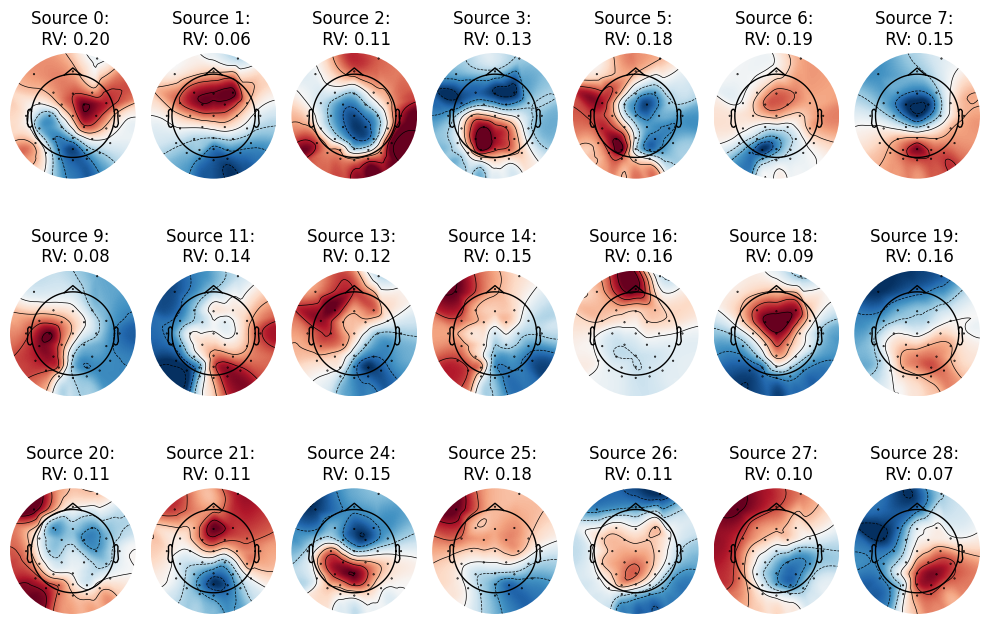

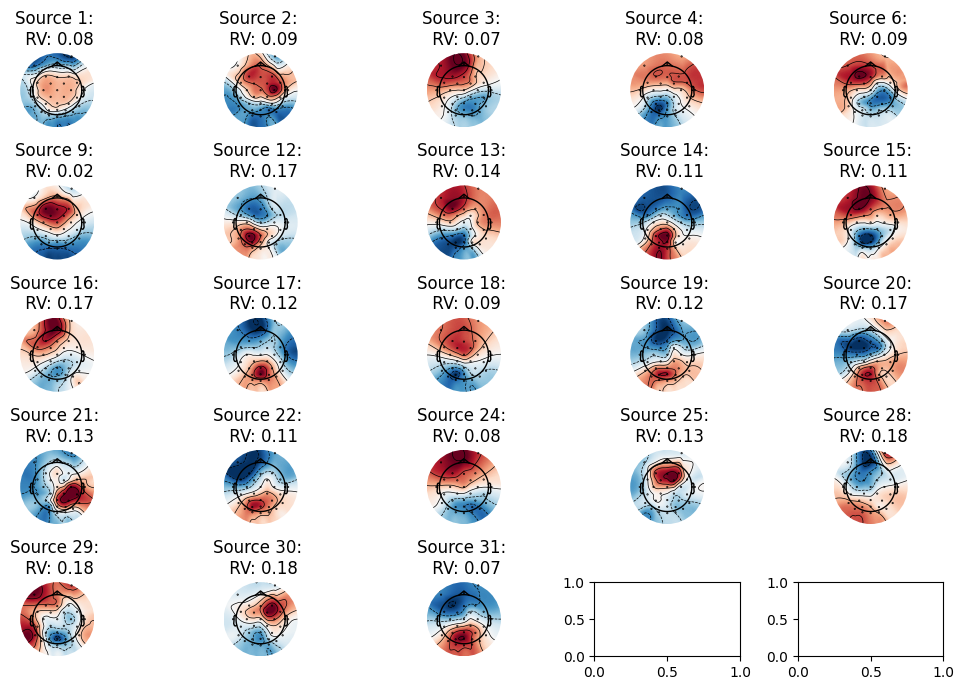

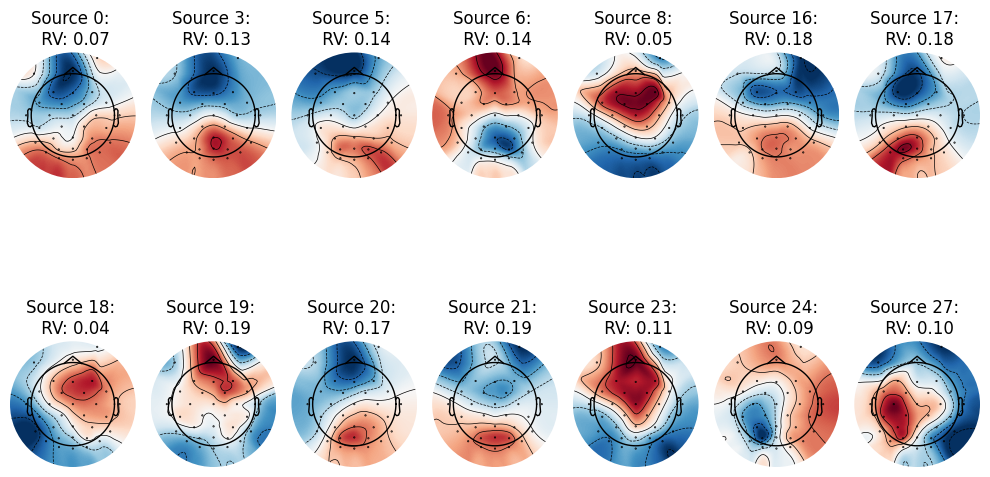

In [12]:
for i in range(number_Of_Patients):
    pmf_plot(r, linear_Maps[i], raw, dip_pmf_rvs_patients[i], threshold)

In [13]:
# Filtering based on RVs

selected_pmfs_patients = []

for i in range(number_Of_Patients):
    dip_pmf_rvs = dip_pmf_rvs_patients[i]
    selected_pmfs = [idx for idx, rv in enumerate(dip_pmf_rvs) if rv < threshold]
    selected_pmfs_patients.append(selected_pmfs)

selected_pmfs

[0, 3, 5, 6, 8, 16, 17, 18, 19, 20, 21, 23, 24, 27]

# Source Localization


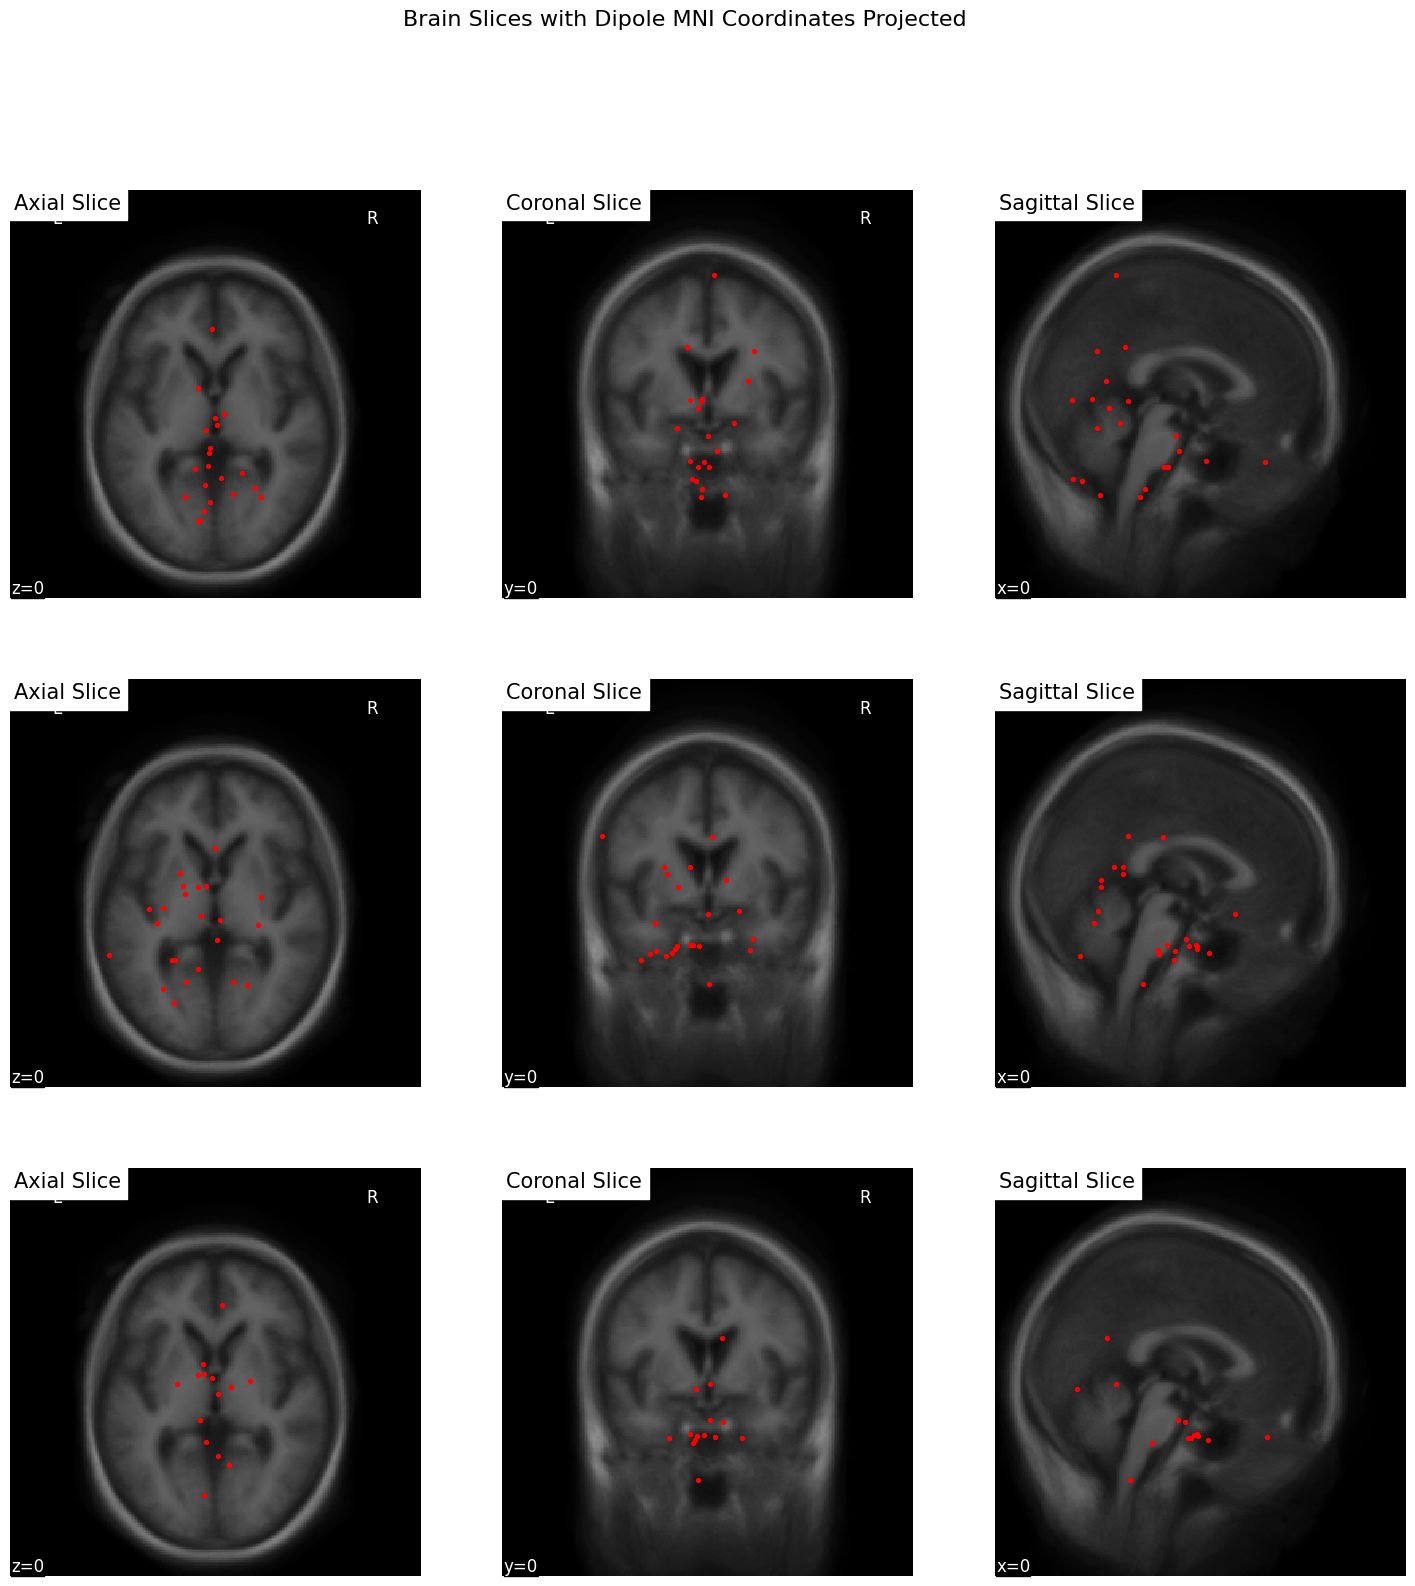

In [14]:
# Load the MRI data
# fs_dir = 'path_to_your_freesurfer_directory'
t1_fname = os.path.join(fs_dir, "mri", "T1.mgz")
img = nib.load(t1_fname)

# Create a figure with subplots for each set of coordinates
fig, axes = plt.subplots(number_Of_Patients, 3, figsize=(18, 6 * number_Of_Patients))

# Loop through the MNI_coordinates array and plot the slices
for i in range(number_Of_Patients):
    mni_coords = MNI_coordinates[i]
    selected_pmfs = selected_pmfs_patients[i]

    selected_mni_coords = mni_coords[selected_pmfs]

    # Create x_markers, y_markers, and z_markers arrays
    x_markers = np.copy(selected_mni_coords)
    x_markers[:, 0] = 0

    y_markers = np.copy(selected_mni_coords)
    y_markers[:, 1] = 0

    z_markers = np.copy(selected_mni_coords)
    z_markers[:, 2] = 0

    # Plot axial slice
    display = plot_anat(img, display_mode='z', cut_coords=[0], axes=axes[i, 0] if number_Of_Patients > 1 else axes[0], title='Axial Slice');
    display.add_markers(marker_coords=z_markers, marker_color='r', marker_size=8);

    # Plot coronal slice
    display = plot_anat(img, display_mode='y', cut_coords=[0], axes=axes[i, 1] if number_Of_Patients > 1 else axes[1], title='Coronal Slice');
    display.add_markers(marker_coords=y_markers, marker_color='r', marker_size=8);

    # Plot sagittal slice
    display = plot_anat(img, display_mode='x', cut_coords=[0], axes=axes[i, 2] if number_Of_Patients > 1 else axes[2], title='Sagittal Slice');
    display.add_markers(marker_coords=x_markers, marker_color='r', marker_size=8);

# Add an overall title
fig.suptitle('Brain Slices with Dipole MNI Coordinates Projected', fontsize=16)

# Adjust layout
# plt.tight_layout()

# Show the plot
# plt.savefig("PMFMap.jpg")
plt.show();

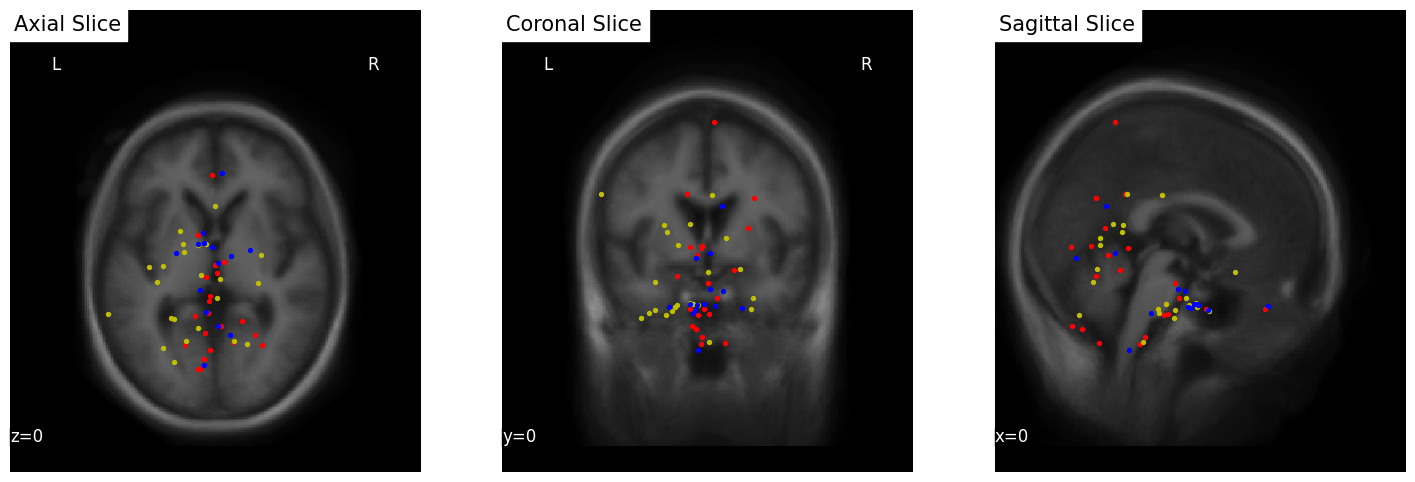

In [15]:
# Load the MRI data
# fs_dir = 'path_to_your_freesurfer_directory'
t1_fname = os.path.join(fs_dir, "mri", "T1.mgz")
img = nib.load(t1_fname)

# Create a figure with subplots for each set of coordinates
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

display_z = plot_anat(img, display_mode='z', cut_coords=[0], axes=axes[0], title='Axial Slice');

display_y = plot_anat(img, display_mode='y', cut_coords=[0], axes=axes[1], title='Coronal Slice')

display_x = plot_anat(img, display_mode='x', cut_coords=[0], axes=axes[2], title='Sagittal Slice')

colors = ['r', 'y', 'b', 'g', 'c', 'm', 'k']  # Add more colors if needed


# Loop through the MNI_coordinates array and plot the slices
for i in range(number_Of_Patients):
    mni_coords = MNI_coordinates[i]
    selected_pmfs = selected_pmfs_patients[i]

    selected_mni_coords = mni_coords[selected_pmfs]

    # Create x_markers, y_markers, and z_markers arrays
    x_markers = np.copy(selected_mni_coords)
    x_markers[:, 0] = 0

    y_markers = np.copy(selected_mni_coords)
    y_markers[:, 1] = 0

    z_markers = np.copy(selected_mni_coords)
    z_markers[:, 2] = 0

    color = colors[i % len(colors)]

    # Plot axial slice
    display_z.add_markers(marker_coords=z_markers, marker_color=color, marker_size=8)

    # Plot coronal slice
    display_y.add_markers(marker_coords=y_markers, marker_color=color, marker_size=8);

    # Plot sagittal slice
    display_x.add_markers(marker_coords=x_markers, marker_color=color, marker_size=8);

# Add an overall title
fig.suptitle('', fontsize=16)

# Adjust layout
# plt.tight_layout()

# Show the plot
plt.show();

##### Each color represents the sources associated with a distinguished patient.